# Robot Policies

A robot policy is the decision-making core of a robot - a model that takes in observations (images, sensor data, motor states) from the world and outputs actions (motor control) to take. Most dominant type of policies today are referred to as Vision-Language-Action (VLA) models.

In this notebook we will learn about the Action Chunking Transformer (ACT) and how to use this policy in a simple gym environment. Then we will explore what VLA datasets look like and how to run it locally on your Ryzen AI machine.

## Goals

* Familiarization with robot policies
* Run the ACT in a simulated gym environment
* Learn how VLA models work

## References

* [ACT](https://github.com/tonyzhaozh/act)
* [gym-aloha](https://github.com/huggingface/gym-aloha)
* [SmolVLA](https://huggingface.co/blog/smolvla)

## ACT

While not a VLA, the Action Chunking Transformer is a seminal paper in robot learning that [introduced the concept of action chunks](https://arxiv.org/abs/2304.13705) - instead of predicting one action at a time autoregressively which was SoTA at the time, this model predicted multiple actions at each inference step. 

Here we will explore how to setup a gym environment and go through some simple scripts from the official ACT repository on training and rolling out the model. You can adapt these steps for your own datasets.

### Using the Aloha Gym

Example code adapted from [gym-aloha](https://github.com/huggingface/gym-aloha)

In [ ]:
import imageio
import gymnasium as gym
import numpy as np
import gym_aloha

#env = gym.make("gym_aloha/AlohaTransferCube-v0")
env = gym.make("gym_aloha/AlohaInsertion-v0")

observation, info = env.reset()
frames = []

for _ in range(1200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print ('reward=%d, info=%s' % (reward, info["is_success"]))
    image = env.render()
    frames.append(image)

    if terminated or truncated:
        observation, info = env.reset()

env.close()
imageio.mimsave("gym.mp4", np.stack(frames), fps=25)

In [ ]:
from IPython.display import Video
Video("gym.mp4")

In [2]:
from act.policy import ACTPolicy
import imageio
import gymnasium as gym
import numpy as np
import gym_aloha

#env = gym.make("gym_aloha/AlohaTransferCube-v0")
env = gym.make("gym_aloha/AlohaInsertion-v0")

observation, info = env.reset()
frames = []

#for _ in range(1200):
#    action = env.action_space.sample()
#    observation, reward, terminated, truncated, info = env.step(action)
#    print ('reward=%d, info=%s' % (reward, info["is_success"]))
#    image = env.render()
#    frames.append(image)##
#
#    if terminated or truncated:
#        observation, info = env.reset()
#
#env.close()
#imageio.mimsave("gym.mp4", np.stack(frames), fps=25)

SyntaxError: invalid syntax (56986300.py, line 1)

### ACT Policy Training & Rollouts

The code cells below run scripts from the official ACT repository to record episodes, train the policy, and evaluate it.

In [ ]:
!sudo python ../act/record_sim_episodes.py \
    --task_name sim_transfer_cube_scripted \
    --dataset_dir sim_transfer_cube_scripted \
    --num_episodes 1

In [ ]:
!sudo HSA_OVERRIDE_GFX_VERSION=11.0.0 python ../act/imitate_episodes.py \
--task_name sim_transfer_cube_scripted \
--ckpt_dir checkpoints \
--policy_class ACT --kl_weight 10 --chunk_size 100 --hidden_dim 512 --batch_size 8 --dim_feedforward 3200 \
--num_epochs 1 --lr 1e-5 \
--seed 0

In [ ]:
!sudo HSA_OVERRIDE_GFX_VERSION=11.0.0 python ../act/imitate_episodes.py \
--task_name sim_transfer_cube_scripted \
--ckpt_dir checkpoints \
--policy_class ACT --kl_weight 10 --chunk_size 100 --hidden_dim 512 --batch_size 8 --dim_feedforward 3200 \
--num_epochs 1 --lr 1e-5 \
--seed 0 --eval

Try also the `AlohaInsertion` policy by changing the env creation line to `env = gym.make("gym_aloha/AlohaInsertion-v0")`

## Vision-Language-Action models

VLAs are the new frontier of robot learning. In addition to vision and text, they incorporate a native action modality, allowing the model to be trained end-to-end from prompt to motor action. 

These models are typically a combination of a VLM, like we've seen before, and a custom action expert that cross-attends to the features extracted by the VLM backbone to control the robot.

### Load a Dataset

Unlike policies trained purely on image data with imitation learning, VLAs need to be conditioned on text as well. Let's visualize a popular training set from LeRobot to see how models like SmolVLA are trained and what they output.

In [1]:
import matplotlib.pyplot as plt
from lerobot.datasets.lerobot_dataset import LeRobotDataset

# Load the dataset
dataset = LeRobotDataset("lerobot/svla_so101_pickplace", video_backend="pyav")

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

First of all - what's inside a single episode?

In [2]:
episode_index = 0
episode_data = dataset[episode_index]

episode_data.keys()

dict_keys(['observation.images.up', 'observation.images.side', 'action', 'observation.state', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'task'])

There's some metadata, images and state seems fairly important! Let's first visualize the camera inputs of this episode.

### Visualize Camera Inputs

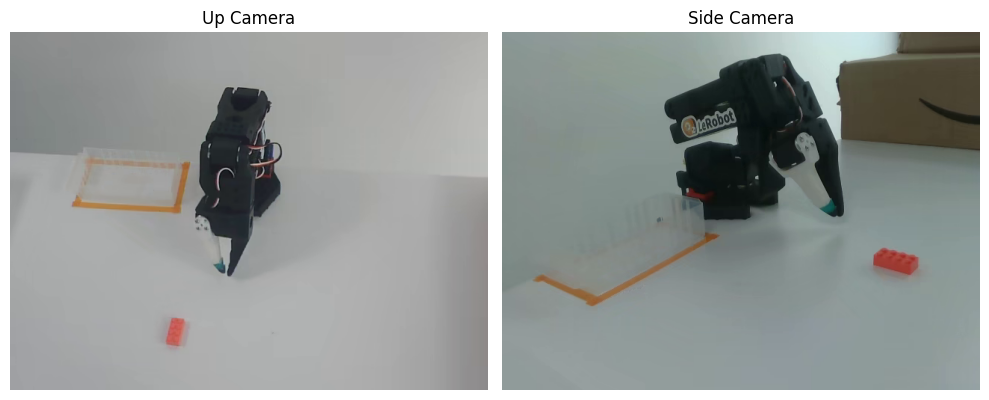

In [3]:
import matplotlib.pyplot as plt

# Up camera
img_up = episode_data['observation.images.up'].numpy()
image_up = img_up.transpose(1, 2, 0)

# Side camera
img_side = episode_data['observation.images.side'].numpy()
image_side = img_side.transpose(1, 2, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_up)
axes[0].set_title("Up Camera")
axes[0].axis("off")

axes[1].imshow(image_side)
axes[1].set_title("Side Camera")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Generally the more cameras the better because it allows the model to reason better spatially and deal with occlusions.

### Visualize Motor States

Looking at the state of the arm we can see 6 motor positions. This is the initial state during the episode.

In [4]:
episode_data['observation.state']

tensor([  1.9561, -98.7437,  98.9242,  74.8198, -51.4530,   1.4094])

Let's visualize how the motor states change as the arm begins to move.

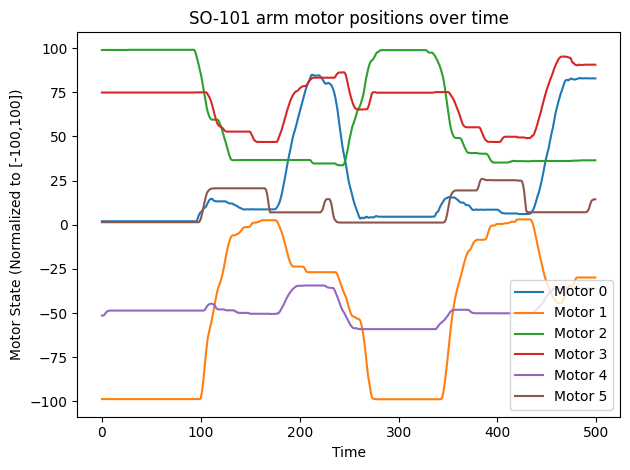

In [5]:
import numpy as np
all = np.zeros((500,6))
for i in range(500):
    episode_data = dataset[i]
    all[i, :] = episode_data['observation.state'].numpy()

plt.plot(all)
plt.title("SO-101 arm motor positions over time")
plt.xlabel("Time")
plt.ylabel("Motor State (Normalized to [-100,100])")
plt.legend([f"Motor {i}" for i in range(6)])
plt.tight_layout()
plt.show()

### Running SmolVLA

Let's load and run the SmolVLA model to see how VLA inference works.

In [6]:
import torch
import time
from lerobot.policies.smolvla.modeling_smolvla import SmolVLAPolicy
from lerobot.policies.smolvla.configuration_smolvla import SmolVLAConfig
from transformers import AutoProcessor

policy = SmolVLAPolicy.from_pretrained("lerobot/smolvla_base",revision="3326b10")
policy.eval();

policy.language_tokenizer = AutoProcessor.from_pretrained(policy.config.vlm_model_name).tokenizer

# Dummy batch config for a single observation
batch_size = 1
img_shape = (3, 512, 512)  # (C, H, W)
# Infer state_dim from the loaded normalization stats
state_dim = policy.normalize_inputs.buffer_observation_state.mean.shape[-1]

dummy_batch = {
    # a single image observation
    "observation.image": torch.rand(batch_size, *img_shape),
    # a single state observation
    "observation.state": torch.rand(batch_size, state_dim),
    "task": ["stack the blocks"] * batch_size,
}

# --- Prepare inputs for the model ---
# The policy expects normalized inputs and specific data preparation.
normalized_batch = policy.normalize_inputs(dummy_batch)
images, img_masks = policy.prepare_images(normalized_batch)
state = policy.prepare_state(normalized_batch)
lang_tokens, lang_masks = policy.prepare_language(normalized_batch)

with torch.no_grad():
    output = policy.model.sample_actions(images, img_masks, lang_tokens, lang_masks, state)

output

`torch_dtype` is deprecated! Use `dtype` instead!


Loading  HuggingFaceTB/SmolVLM2-500M-Video-Instruct weights ...
Reducing the number of VLM layers to 16 ...
[standardise_state_dict] 'normalize_inputs.buffer_observation_state.mean'  ←  ['normalize_inputs.so100-red_buffer_observation_state.mean', 'normalize_inputs.so100_buffer_observation_state.mean']
[standardise_state_dict] 'normalize_inputs.buffer_observation_state.std'  ←  ['normalize_inputs.so100-red_buffer_observation_state.std', 'normalize_inputs.so100_buffer_observation_state.std']
[standardise_state_dict] 'normalize_targets.buffer_action.mean'  ←  ['normalize_targets.so100-red_buffer_action.mean', 'normalize_targets.so100_buffer_action.mean']
[standardise_state_dict] 'normalize_targets.buffer_action.std'  ←  ['normalize_targets.so100-red_buffer_action.std', 'normalize_targets.so100_buffer_action.std']
[standardise_state_dict] 'unnormalize_outputs.buffer_action.mean'  ←  ['unnormalize_outputs.so100-red_buffer_action.mean', 'unnormalize_outputs.so100_buffer_action.mean']
[standa

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]])

## Key Takeaways

- Action Chunking: ACT pioneered predicting multiple actions per inference step - now you can run this fundamental policy on your AI PC.
- VLAs: you now have an appreciation for the end-to-end trained VLAs that take prompts and output actions and are able to run modern models like SmolVLA.

## Next Steps

In the next notebook, we will deploy a VLM as a ROS service node and show how it can be used for robotics applications.

**Continue to**: [4_vlm_ros_integration.ipynb](4_vlm_ros_integration.ipynb)

---
Copyright© 2025 AMD, Inc. SPDX-License-Identifier: MIT